<a href="https://colab.research.google.com/github/MarioROT/CV-MAI/blob/main/Session%207/p7_1_image_classification_using_BoVW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratory #3_2 : Image Classification using Bag of Visual Words

At the end of this laboratory, you would get familiarized with

*   Creating Bag of Visual Words
    *   Feature Extraction
    *   Codebook construction
    *   Classification

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Mount your drive to access the images.
*   Add sufficient comments and explanations wherever necessary.

---

In [1]:
%%shell
git clone https://github.com/mariorot/CV-MAI
mv CV-MAI/scripts/* /content/
mv 'CV-MAI/Session 7/101_ObjectCategories/'* /content/
mv 'CV-MAI/Session 7/Caltech_101_subset/' /content/

Cloning into 'CV-MAI'...
remote: Enumerating objects: 21117, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 21117 (delta 22), reused 16 (delta 7), pack-reused 21072
Receiving objects: 100% (21117/21117), 171.92 MiB | 30.91 MiB/s, done.
Resolving deltas: 100% (121/121), done.
Updating files: 100% (21037/21037), done.


In [210]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [211]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

import os
import numpy as np
from skimage.feature import ORB
from skimage import exposure
from skimage import feature
from skimage.color import rgb2gray
from skimage.io import imread
from scipy.cluster.vq import vq
from matplotlib import pyplot as plt
from skimage import io
from collections import defaultdict
from sklearn.cluster import MiniBatchKMeans

import custom_plots as cp

## Loading dataset

We will use 3 categories from Caltech 101 objects dataset for this experiment. Upload the dataset to the drive and mount it.

In [212]:
# modify the dataset variable with the path from your drive

#We define an empty dictionary an the root folder of the 3 categories
images = []
root_folder = '/content/Caltech_101_subset'

In [213]:
categories = ['butterfly', 'kangaroo', 'dalmatian']

*   Create a list of file and the corresponding labels

In [214]:
# solution

#We charged the images to the dictionary with the proper label and id
for folder_name in os.listdir(root_folder):
  folder_path = os.path.join(root_folder, folder_name)
  for filename in os.listdir(folder_path):
      label = folder_name
      image_path = os.path.join(folder_path, filename)
      images.append( (image_path,label))

In [215]:
print('Total number of images:', len(images))

Total number of images: 244


*   Create a train / test split where the test is 10% of the total data

In [257]:
# solution
from sklearn.model_selection import train_test_split

im_array = np.array(images)
img,labels=im_array[:,0],im_array[:,1]

x_train, x_test, y_train, y_test = train_test_split(img, labels, test_size=0.1, random_state=5,shuffle=True)

print('Train set:', len(x_train))
print('Test set:', len(x_test))


Train set: 219
Test set: 25


*   How do you select the train/test split?

**Solution**

In this case, since the split of the classes was somehow homogeneous  (91 images of butterfly - 37% , 67 images of dalmatian - 28% and 86 images of kangaroos - 35%)  and the test data was only 10% of the total data set, we decided to do it in a random way.

However, this may not be possible in 2 scenarios:

- The distribution of the actual images was not homogeneous. For example having only 10% of an specific class. Because this way, there is a chance that we do not take enough images of the small class for the training set.

- The total training set was small enough to contain only images of the same class.

Since neither of these scenarios were happening we decided to do it randomly.



## Feature Extraction using ORB

The first step is to extract descriptors for each image in our dataset. We will use ORB to extract descriptors.

*   Create ORB detector with 64 keypoints.


In [217]:
# solution
def get_ORB(img1,n):
  descriptor_extractor = feature.ORB(n_keypoints=n)
  descriptor_extractor.detect_and_extract(img1)
  keypoints= descriptor_extractor.keypoints
  descriptors= descriptor_extractor.descriptors

  return descriptors

*   Extract ORB descriptors from all the images in the train set.


In [218]:
def load_img (paths):
  images=[]
  for image in paths:
    read=io.imread(image)
    if len(read.shape)==3:
      if read.shape[2]==3:
        images.append(rgb2gray(read))
    else:
      images.append(read)
  return images

In [219]:
train_img=load_img(x_train)
test_img=load_img(x_test)

In [221]:
from  utils import  get_multi_ORB

_ , all_descriptors=get_multi_ORB(feature.ORB(n_keypoints=64),train_img)

*   What is the size of the feature descriptors? What does each dimension represent in the feature descriptors?

In [222]:
# solution
print("Number of images:",len(all_descriptors))

shapes = set()
for desc in all_descriptors:
  shapes.add(desc.shape)

print("Number of feature descriptors:",shapes)


Number of images: 219
Number of feature descriptors: {(64, 256)}


**Solution**

The size of the feature descriptor is 64x256, which means we have 64 keypoints ot descriptors for each image, with a 256-bit, which is a binary string that represent the local image structure around the key point.



## Codebook Construction

Codewords are nothing but vector representation of similar patches. This codeword produces a codebook similar to a word dictionary. We will create the codebook using K-Means algorithm

*   Create a codebook using K-Means with k=number_of_classes*10
*   Hint: Use sklearn.cluster.MiniBatchKMeans for K-Means

In [223]:
#Solution

#First we put all the descriptors in a list
all_descriptors=all_descriptors.reshape(219*64,256)

In [224]:
#Then we apply K-Means

k = len(categories) * 10
kmeans = MiniBatchKMeans(n_clusters=k,random_state=8)
kmeans.fit(all_descriptors)

codebook = kmeans.cluster_centers_

print("Codebook:")
print(codebook)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Codebook:
[[0.48094079 0.12570965 0.38442822 ... 0.82887267 0.46958637 0.5458232 ]
 [0.49461787 0.87621098 0.44940797 ... 0.41011841 0.77018299 0.51991389]
 [0.33750745 0.62373286 0.72629696 ... 0.48777579 0.65891473 0.29159213]
 ...
 [0.7755102  0.35003092 0.57328386 ... 0.73407545 0.53494125 0.30983302]
 [0.35301669 0.90885751 0.46405648 ... 0.40243902 0.78754814 0.87227214]
 [0.29641485 0.28489117 0.56402049 ... 0.40588988 0.38348271 0.50576184]]


In [225]:
predicted=[kmeans.predict(i.reshape(1, -1))[0] for i in all_descriptors]

In [226]:
train_rep=np.array(predicted).reshape(219,64)

*   Create a histogram using the cluster centers for each image descriptor.
    *   Remember the histogram would be of size *n_images x n_clusters*.

<BarContainer object of 30 artists>

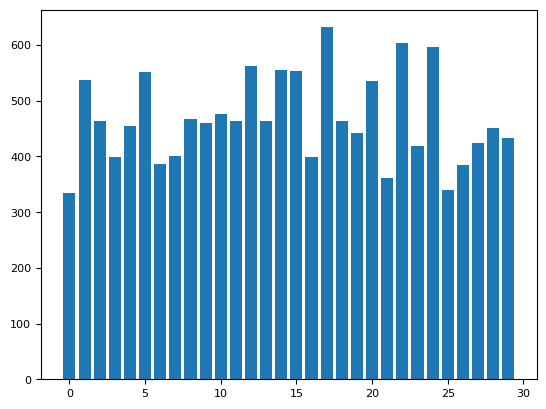

In [227]:
import matplotlib.pyplot as plt
unique, counts = np.unique(predicted, return_counts=True)
plt.bar(unique,counts)

# Testing the Classification Model

*   Extract descriptors using ORB for the test split
*   Use the previously trained k-means to generate the histogram
*   Use the classifier to predict the label


In [228]:
_ , all_descriptors_test=get_multi_ORB(feature.ORB(n_keypoints=64),test_img)

In [229]:
all_descriptors_test=all_descriptors_test.reshape(25*64,256)

In [230]:
#K-means
predicted_test=[kmeans.predict(i.reshape(1, -1))[0] for i in all_descriptors_test]

In [231]:
test_rep=np.array(predicted_test).reshape((25, 64))


# Creating Classification Model

*   The next step is to create a classification model. We will use a C-Support Vector Classification for creating the model.



*   Use GridSearchCV to find the optimal value of C and Gamma.

In [232]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [233]:
param_grid = {'C': np.linspace(0.1,5,num=25), 'gamma': [0.01, 0.1, 1,'scale','auto']}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_rep, y_train)

print("Best Parameters:", grid_search.best_params_)

# Evaluate the model on the test set with the best parameters
best_svc = grid_search.best_estimator_
y_pred = best_svc.predict(test_rep)

Best Parameters: {'C': 1.1208333333333336, 'gamma': 'scale'}


*   Calculate the accuracy score for the classification model

In [234]:
# solution
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Set:", accuracy)

Accuracy on Test Set: 0.24


*   Generate the confusion matrix for the classification model

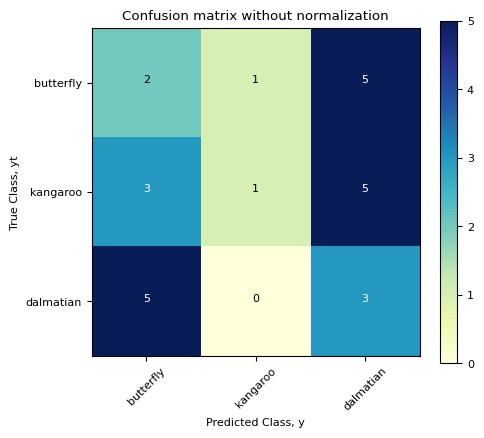

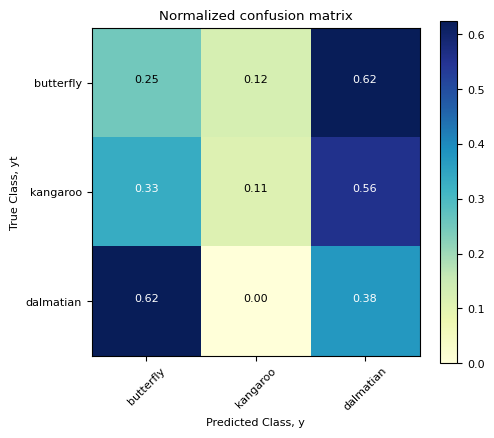

In [235]:
# solution
from sklearn.metrics import confusion_matrix
cp.plot_confusion_matrix(confusion_matrix(y_test, y_pred),categories, (5,5), colors='YlGnBu', normalize=False, fsizes={'font':8})
cp.plot_confusion_matrix(confusion_matrix(y_test, y_pred),categories, (5,5), colors='YlGnBu', normalize=True, fsizes={'font':8})


*   Why do we use Clustering to create the codebook?
*   What are the other techniques that can be used to create the codebook?

**Solution**

- We use the clustering since we want to bring together all the descriptors that are similar in order to not reduce the amount of keypoints and conserve the more representatives patches that contain the most descriptors.

- Since the main objective is to keep the similar information, most of the common clustering techniques will suit properly this task, as the hierarchical or agglomerative clustering. However we can use also some techniques as PCA that tries to achieve a dimmensionality reduction while keeping most of the data.

# Increased Feature Dimensions

*   Repeat the classification using features of 256 ORB keypoints.

In [236]:
_ , all_descriptors_2=get_multi_ORB(feature.ORB(n_keypoints=256),train_img)

In [237]:
y_train=np.array([ y_train[j] for j,i in enumerate(all_descriptors_2) if i.shape[0]==256])

In [240]:
all_descriptors_2=np.array([i for i in all_descriptors_2 if i.shape[0]==256 ]).reshape(219*256,256)

In [241]:

k = len(categories) * 10
kmeans = MiniBatchKMeans(n_clusters=k,random_state=8)
kmeans.fit(all_descriptors_2)

codebook = kmeans.cluster_centers_

print("Codebook:")
print(codebook)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Codebook:
[[0.51514482 0.60800354 0.47910679 ... 0.44395313 0.55184612 0.60004422]
 [0.43281779 0.85693572 0.17182214 ... 0.36636056 0.71145481 0.86394393]
 [0.83824966 0.12365696 0.55088885 ... 0.66888064 0.38659895 0.59601485]
 ...
 [0.5125606  0.72344645 0.64676069 ... 0.49140591 0.79528427 0.46011459]
 [0.2697274  0.43390039 0.40889527 ... 0.37733142 0.27628612 0.42447223]
 [0.76198426 0.75459098 0.54901026 ... 0.50226568 0.73861197 0.72549487]]


In [242]:
predicted_2=np.array([kmeans.predict(i.reshape(1, -1))[0] for i in all_descriptors_2])

In [244]:
train_rep_2=np.array(predicted_2).reshape((219, 256))

In [258]:
_ , all_descriptors_test_2=get_multi_ORB(feature.ORB(n_keypoints=256),test_img)

In [262]:
y_test=np.array([ y_test[j] for j,i in enumerate(all_descriptors_test_2) if i.shape[0]==256])

In [264]:
all_descriptors_test_2=np.array([i for i in all_descriptors_test_2 if i.shape[0]==256 ]).reshape(24*256,256)

In [265]:
all_descriptors_test_2.shape
all_descriptors_test_2=all_descriptors_test_2.reshape(24*256,256)

In [266]:
predicted_test_2=[kmeans.predict(i.reshape(1, -1))[0] for i in all_descriptors_test_2]

In [268]:
test_rep_2=np.array(predicted_test_2).reshape((24, 256))

In [269]:
param_grid = {'C': np.linspace(0.1,5,num=25), 'gamma': [0.01, 0.1, 1,'scale','auto']}

grid_search_2 = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search_2.fit(train_rep_2, y_train)

print("Best Parameters:", grid_search_2.best_params_)

# Evaluate the model on the test set with the best parameters
best_svc = grid_search_2.best_estimator_
y_pred_2 = best_svc.predict(test_rep_2)

# solution
accuracy = accuracy_score(y_test, y_pred_2)
print("Accuracy on Test Set:", accuracy)


Best Parameters: {'C': 1.529166666666667, 'gamma': 'scale'}
Accuracy on Test Set: 0.5


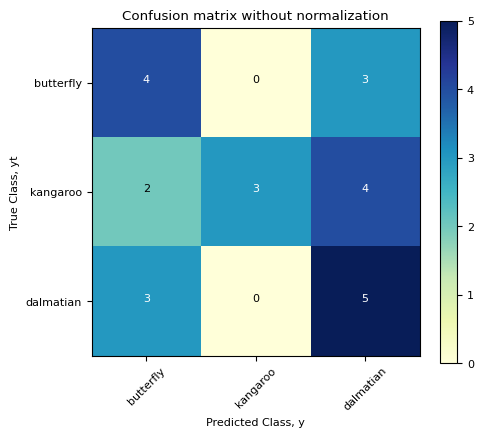

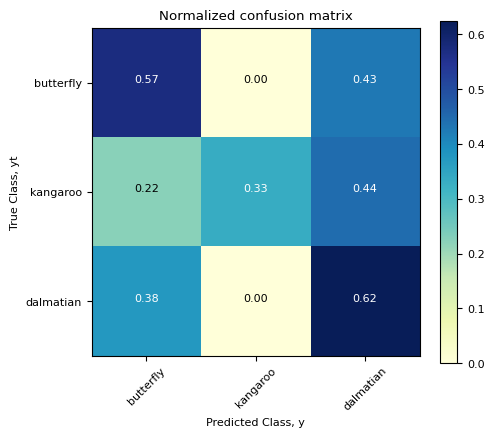

In [270]:
from sklearn.metrics import confusion_matrix
cp.plot_confusion_matrix(confusion_matrix(y_test, y_pred_2),categories, (5,5), colors='YlGnBu', normalize=False, fsizes={'font':8})
cp.plot_confusion_matrix(confusion_matrix(y_test, y_pred_2),categories, (5,5), colors='YlGnBu', normalize=True, fsizes={'font':8})


*   What is the difference in classifier performance between using 64 keypoints and 256 keypoints?

**Solution**

The accuracy increases since we are taking into account more details of the image

*   Will further adding more keypoints increase the performance of the algorithm?

**Solution**

At some point adding more keypoints may work, however, there is a limit where more data will not impply more precision, since we are not giving more information, and it only increases the computation time.
